In [6]:
import datetime as dt
import numpy as np
import scipy as sp
import spacepy.pycdf as pycdf
import matplotlib.pyplot as plt
%matplotlib inline

In [78]:
AFG      = pycdf.CDF('X:/data/ftp/mms3/afg/srvy/l2pre/2015/05/mms3_afg_srvy_l2pre_20150506_v3.11.0.cdf')
AFG_1026 = pycdf.CDF('X:/data/ftp/mms1/afg/srvy/l2pre/2015/10/mms1_afg_srvy_l2pre_20151026_v3.14.0.cdf')
debug    = pycdf.CDF('X:/data/ftp/mms1/fpi/fast/l2/des-debug/2015/10/mms1_fpi_fast_l2_des-debug_20151026040000_v3.1.0.cdf')

In [227]:
def bisect_epochs(target_epoch,epochs):
    low_index   = 0
    high_index  = len(epochs)

    old_trial_index = low_index
    trial_index     = high_index
    
    while( abs(old_trial_index - trial_index) > 1):
        old_trial_index = trial_index
        trial_index     = np.int(np.floor((high_index + low_index)/2.0 ))
        trial_epoch     = epochs[trial_index]
        if (trial_epoch - target_epoch).total_seconds() < 0:
            low_index       = trial_index
        else:
            high_index = trial_index

    #a test for what may happen for odd number of points in the 
    #epoch array
    if(high_index == low_index):
        #found out if the common epoch is above or below target
        if (epochs[high_index] - target_epoch).total_seconds() < 0:
            high_index = high_index + 1
        else:
            low_index  = low_index - 1

    return low_index, high_index

In [248]:
def fetch_AFG_B_field(cdf_fh,species):
    B       = np.zeros( (len(cdf_fh['dist']['Epoch']),4) )
    B_str   = '%s_afg_srvy_l2pre_dmpa' % species

    counter = 0
    for e in cdf_fh['dist']['Epoch']:
        low_index, high_index = bisect_epochs(e,cdf_fh['AFG']['Epoch'])
        epoch_low    = cdf_fh['AFG']['Epoch'][low_index]
        epoch_high   = cdf_fh['AFG']['Epoch'][high_index]        
        h            = (epoch_high - epoch_low).total_seconds()
        dt           = (epoch_high - e).total_seconds()
        B_low        = cdf_fh['AFG'][B_str][low_index]
        B_high       = cdf_fh['AFG'][B_str][high_index]
        B_e          = B_low + (B_high-B_low)*(dt/h)
        B[counter,:] = B_e
        counter      = counter + 1
        
    B[:,3] = np.sqrt(B[:,0]**2 + B[:,1]**2 + B[:,2]**2)
    B[:,0] = B[:,0]/B[:,3]
    B[:,1] = B[:,1]/B[:,3]
    B[:,2] = B[:,2]/B[:,3]

    return B

In [249]:
cdf_fh = {'dist':debug, 'AFG':AFG_1026}

In [250]:
myB = fetch_AFG_B_field(cdf_fh,'mms1')

In [251]:
myB[1]

array([  0.37038256,  -0.11371891,   0.92189195,  63.93728021])

In [256]:
cdf_fh['dist']['mms1_des_bentPipeB_Norm'][0]

array(65.96875)

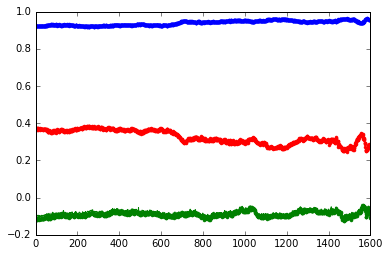

In [261]:
plt.plot(cdf_fh['dist']['mms1_des_bentPipeB_X_DSC'],'r-')
plt.plot(myB[:,0],'r.')
plt.plot(cdf_fh['dist']['mms1_des_bentPipeB_Y_DSC'],'g-')
plt.plot(myB[:,1],'g.')
plt.plot(cdf_fh['dist']['mms1_des_bentPipeB_Z_DSC'],'b-')
plt.plot(myB[:,2],'b.')

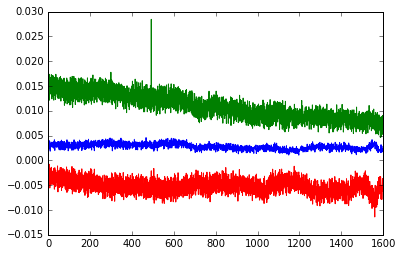

In [262]:
plt.plot(cdf_fh['dist']['mms1_des_bentPipeB_X_DSC'] - myB[:,0],'r-')
plt.plot(cdf_fh['dist']['mms1_des_bentPipeB_Y_DSC'] - myB[:,1],'g-')
plt.plot(cdf_fh['dist']['mms1_des_bentPipeB_Z_DSC'] - myB[:,2],'b-')